In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import time
%matplotlib inline

In [3]:
#Import packages specific to this project(machine learning)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

In [ ]:
# Classifier Cell -  DO NOT RUN - contents replaced inline after testing here
def classifier_generator(x_features, y_labels, verbose=False):
    
    #Fit a standard scaler (and shuffler)
    sc = StandardScaler().fit(x_features)
    x_scaled = sc.transform(x_features)
    
    #Split the test set into training and validation set( keeping random state as constant for predictability)
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_labels, test_size=0.20, random_state=0)
    
    #Create an SVC classifier
    classifier = LinearSVC()
    classifier.fit( x_features, y_labels )
    
    if( verbose == True):
        #If verbose is requested, we need to calculate accuracy and print it
        y_pred = classifier.predict(x_test)
        acc_score = accuracy_score(y_test, y_pred)
        print("Accuracy score is: %d" %acc_score)
    
    return classifier

In [4]:
#Cell for extracting features from color space and istogram of gradients(HOG)

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# May not be necessary - Manbir
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    print("ColorSpace: ", color_space, "orient: ", orient, "pix_per_cell: ", pix_per_cell)
    print("Cells: ", cell_per_block, "hog_channel: ", hog_channel, "hog_feat: ", hog_feat)
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [460]:
#Define constantds to be used for this solution after optimization
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off - As feature concatenation is giving me memory errors
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

In [461]:
# Extract features Test
test_car_imgs = [None, None]
idx = np.random.randint(0, len(car_images))
test_car_imgs[0]= car_images[idx]
test_car_imgs[1]= car_images[idx]
car_features = extract_features(test_car_imgs, color_space=color_space, 
                 spatial_size=spatial_size, hist_bins=hist_bins, 
                 orient=orient, pix_per_cell=pix_per_cell, 
                 cell_per_block=cell_per_block, 
                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                 hist_feat=hist_feat, hog_feat=hog_feat)

x_features = np.asarray(car_features)
print(x_features.shape)
print(x_features)

ColorSpace:  HSV orient:  12 pix_per_cell:  8
Cells:  2 hog_channel:  ALL hog_feat:  True
(2, 8784)
[[ 0.          0.          1.         ...,  0.01312517  0.01287856
   0.00240696]
 [ 0.          0.          1.         ...,  0.01312517  0.01287856
   0.00240696]]


Car images count 8792
Non car images count 8968


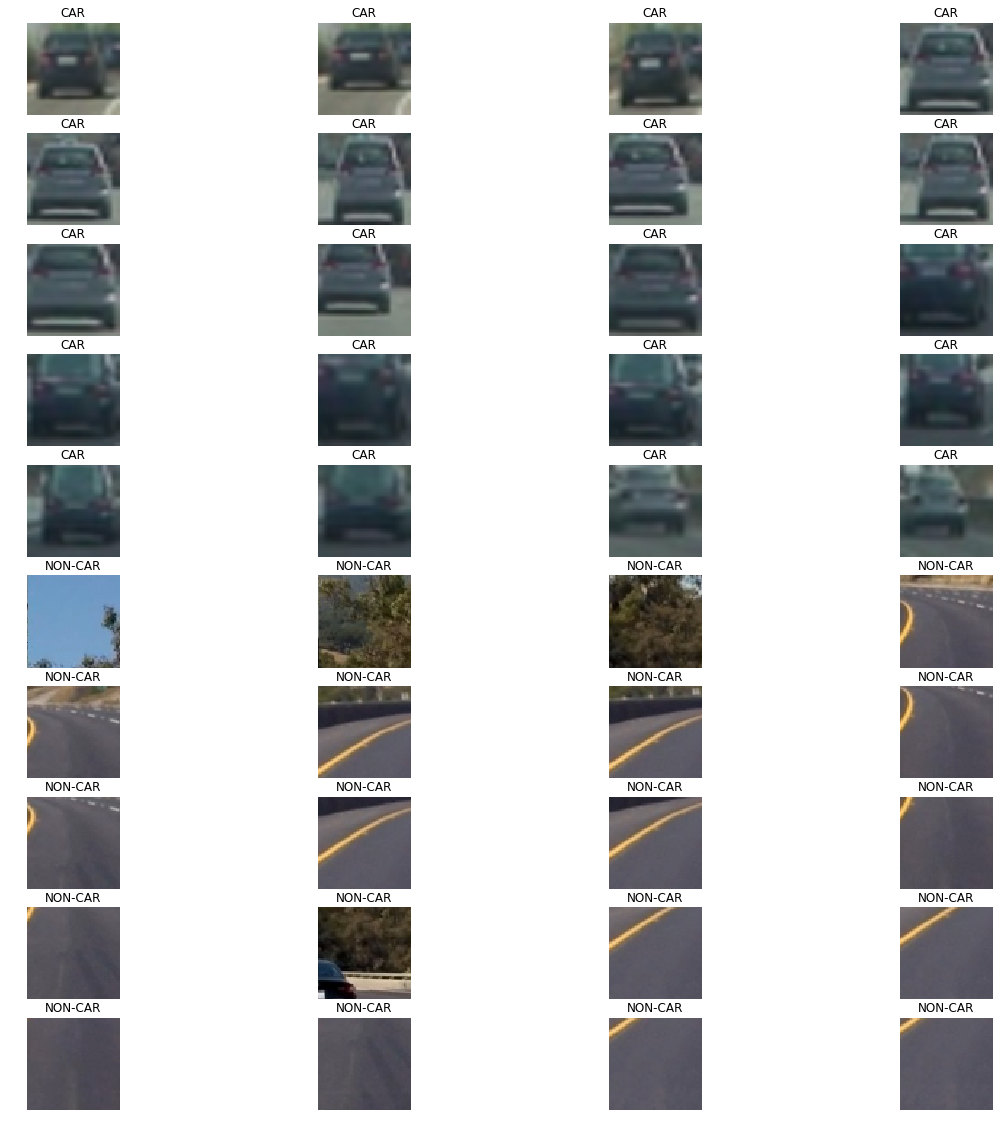

In [462]:
#Import the data set and gain insights
import glob
car_images = glob.glob('DataSet/vehicles/**/*.png')
non_car_images = glob.glob('DataSet/non-vehicles/**/*.png')

print("Car images count %d" %len(car_images) )
print("Non car images count %d" %len(non_car_images))

#Attempt at visualizing the image set
plt.close('all') # Close all exiting plots
nCol = 4 # 4 images per row
nRow = 10  # Need 10 rows for 5 rows of vehicles and 5 rows of non-vehicles
#https://matplotlib.org/examples/pylab_examples/subplots_demo.html
figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
axis = axis.reshape(-1)
#Have to get rid of rest of all the boundary axis
for i in range((nCol*nRow)):
    axis[i].axis('off')

ctr = 0
for i in list(range(20)):
    img = cv2.imread(car_images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axis[ctr].set_title('CAR')
    axis[ctr].imshow(img)
    ctr += 1

for i in list(range(20)):
    img = cv2.imread(non_car_images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axis[ctr].set_title('NON-CAR')
    axis[ctr].imshow(img)
    ctr += 1

0.07 time to extract hog features...


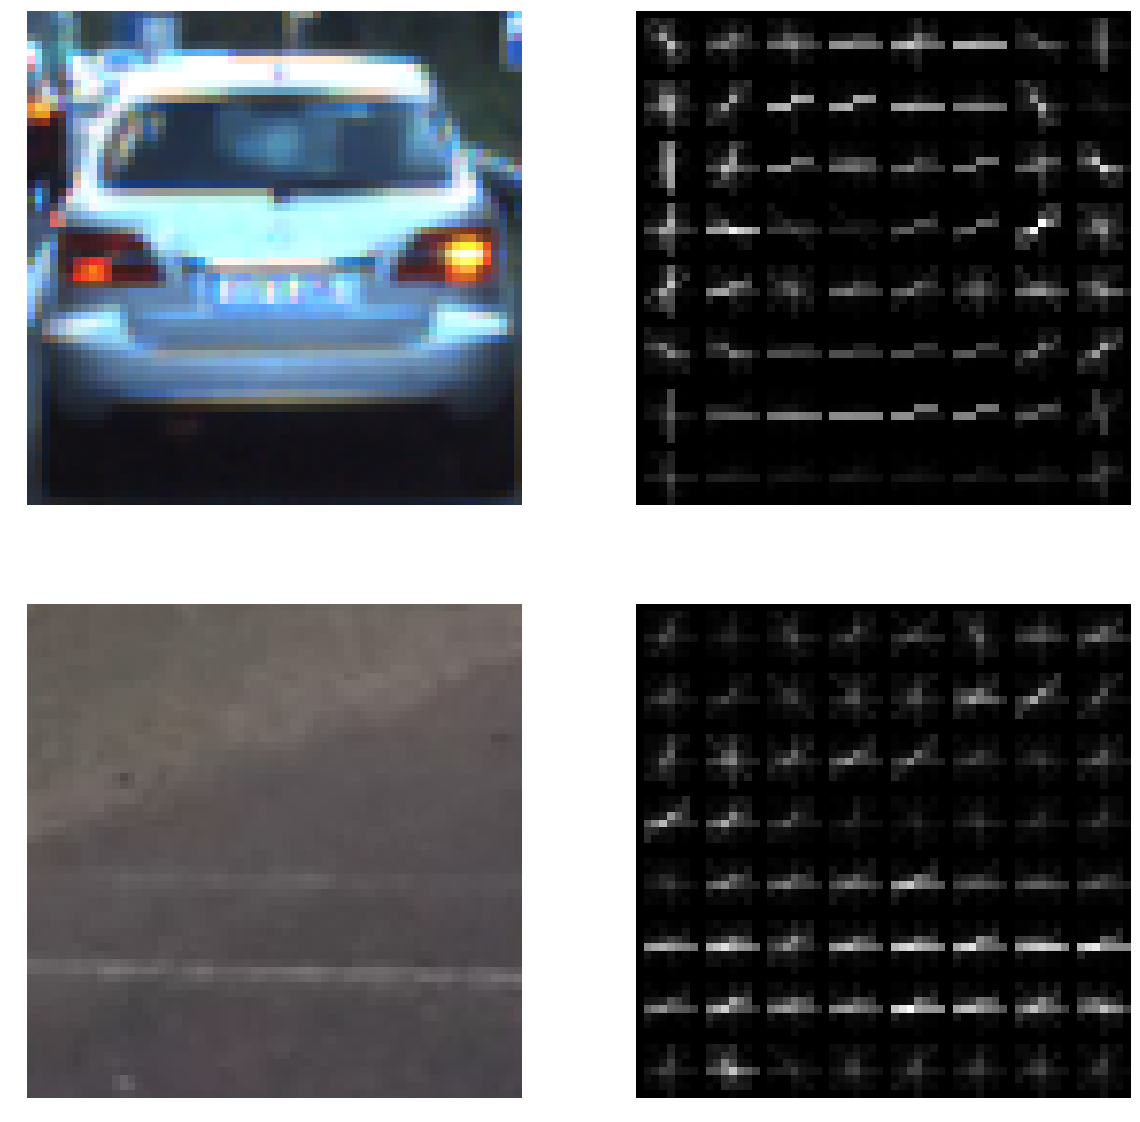

In [463]:
# Cell to display hog features of 1 car image, 1 non-car image
plt.close('all')
nCol = 2 # 2 images per row
nRow = 2  # Need 2 rows 
#https://matplotlib.org/examples/pylab_examples/subplots_demo.html
figure,axis = plt.subplots(nRow, nCol, figsize=(20,20))
axis = axis.reshape(-1)
#Have to get rid of rest of all the boundary axis
for i in range((nCol*nRow)):
    axis[i].axis('off')

t1 = time.time() # start time
ctr = 0
hg_channel = 1

idx = np.random.randint(0, len(car_images))
car_img = mpimg.imread(car_images[idx])
_, feat_car = get_hog_features(car_img[:,:,hg_channel], orient, 
                               pix_per_cell, cell_per_block, vis=True, feature_vec=True)

axis[ctr].imshow(car_img)
ctr += 1
axis[ctr].imshow(feat_car, cmap='gray')
ctr += 1

idx = np.random.randint(0, len(non_car_images))
non_car_img = mpimg.imread(non_car_images[idx])
_, non_feat_car = get_hog_features(non_car_img[:,:,hg_channel], orient, 
                               pix_per_cell, cell_per_block, vis=True, feature_vec=True)

axis[ctr].imshow(non_car_img)
ctr += 1
axis[ctr].imshow(non_feat_car, cmap='gray')

t2 = time.time()
print(round(t2-t1, 2), 'time to extract hog features...')

In [464]:
plt.close('all')
#Cell to generate features list, train classifier and pickle classifier
t1 = time.time() # Start time
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time() #Time for car images
print(round(t2-t1, 2), 'Seconds to extract car features...')

notcar_features = extract_features(non_car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t3 = time.time() #Time for non-car images
print(round(t3-t2, 2), 'Seconds to extract non-car features...')



ColorSpace:  HSV orient:  12 pix_per_cell:  8
Cells:  2 hog_channel:  ALL hog_feat:  True
78.32 Seconds to extract car features...
ColorSpace:  HSV orient:  12 pix_per_cell:  8
Cells:  2 hog_channel:  ALL hog_feat:  True
109.86 Seconds to extract non-car features...


In [465]:
t1 = time.time()
#Convert from list to array
count_cars = len(car_features)
car_features = np.asarray(car_features)

count_noncars = len(notcar_features)
notcar_features = np.asarray(notcar_features)

x_features = np.vstack((car_features, notcar_features)).astype(np.float64)
y_labels = np.hstack((np.ones(count_cars), np.zeros(count_noncars)))

t2 = time.time()
print('Test set generation complete')
print(round(t2-t1, 2), 'Time taken to generate data...')
print("Features shape: ", x_features.shape, " Labels shape: ", y_labels.shape)

Test set generation complete
2.46 Time taken to generate data...
Features shape:  (17760, 8784)  Labels shape:  (17760,)


In [466]:
t1 = time.time()
scaler = StandardScaler().fit(x_features)
x_scaled = scaler.transform(x_features)

#Split the test set into training and validation set( keeping random state as constant for predictability)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_labels, test_size=0.2, random_state = 0)

t2 = time.time()
print(round(t2-t1, 2), 'Time taken to scale and split...')

7.01 Time taken to scale and split...


In [467]:
t1 = time.time()

#Create an SVC classifier
classifier = LinearSVC()
classifier.fit( x_train, y_train )

t2 = time.time()
print(round(t2-t1, 2), 'Time taken to train classifier...')

7.43 Time taken to train classifier...


In [468]:
t1 = time.time()

acc_score = classifier.score(x_test, y_test)
print("Accuracy score is", np.round(acc_score,4))


Accuracy score is 0.9904


In [469]:
#Save classifier and scaler
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(classifier, 'classifier.pkl')

['classifier.pkl']

In [ ]:
## PART 2 - Sliding window and heat map

In [470]:
#Cell to load pickled classifiers and scalers
classifier = joblib.load('classifier.pkl')
scaler = joblib.load('scaler.pkl')

In [528]:
# Find cars in lower half of image
# Function taken from class and modified as per need - multiple color spaces and no spatial binning
# Creates a HOG sampling window over lower screen.
# We will use different scaling factors to locate cars over entire road space
def find_cars(img, ystart, ystop, color_space, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,450:,:]
    
    rectangle_boxes=[]
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            ### Below code is commented as we do not use spatial features and histogram features
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            
            test_features =  np.hstack((spatial_features, hog_features)).reshape(1, -1)
            #test_features =  np.hstack((spatial_features, hist_feat, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_features)       
            test_prediction = svc.predict(test_features)
            
            #In hindisght, we do not need standard scaling as we are only using HOG features, 
            # But since we have a scaler which we used in classification, we will use it here
            #test_features = X_scaler.transform(hog_features.reshape(1,-1))
            #test_prediction = svc.predict(test_features)
            
            # Our labels were only 0/1. Hopefully the classifier will do the same 
            if test_prediction == 1 or draw_all_rects == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangle_boxes.append(((xbox_left+450, ytop_draw+ystart),(xbox_left+450+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangle_boxes

# Function to draw boxes - taken from class
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

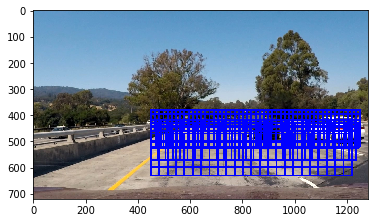

In [529]:
#Test for rectangles
img = mpimg.imread('test_images/test1.jpg')

rectangles=[]
#We could possibly use different regions for different scale sizes. But for now let's keep one lowe half size
# for all scales. Will optimize based on time available

y_start=380
y_end=480
scale=1.00
rectangles += find_cars(img, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = True)

y_start=420
y_end=550
scale=1.25
rectangles += find_cars(img, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = True)

y_start=430
y_end=570
scale=1.50
rectangles += find_cars(img, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = True)

#test_img = draw_boxes(img, rectangles, color=(0,255,0), thick=6)

y_start=460
y_end=610
scale=1.75
rectangles += find_cars(img, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = True)


y_start=470
y_end=690
scale=2.00
rectangles += find_cars(test_img, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = True)



test_img = draw_boxes(img, rectangles, color=(0,0,255), thick=6)
plt.imshow(test_img)

##Observations: 
#scale 1.00  need atleast 80 pixels to work - Best range 400 to 500
# scale 1.25 needs 100 pixels to work best range 420 to 550
# scale 1.50 needs 120 pixels to work - Best start 400 - recommend 440 to 560
# scale 1.75 needs 140 - recommend 440 to 610
#Scale 2.00  needs 160 pixels to work - Start from 450 to 650


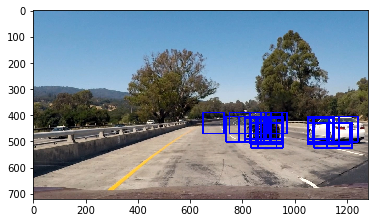

In [601]:
# Test to generate boxes over scale 1, 1.5, 2.0
img = mpimg.imread('test_images/test1.jpg')

rectangles=[]
#We could possibly use different regions for different scale sizes. But for now let's keep one lowe half size
# for all scales. Will optimize based on time available
y_start=390
y_end=500
scale=1.00
rectangles += find_cars(img, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = False)

y_start=390
y_end=540
scale=1.25
rectangles += find_cars(img, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = False)

y_start=405
y_end=570
scale=1.50
rectangles += find_cars(img, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = False)

#test_img = draw_boxes(img, rectangles, color=(0,255,0), thick=6)

y_start=460
y_end=610
scale=1.75
rectangles += find_cars(img, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = False)


y_start=470
y_end=690
scale=2.00
rectangles += find_cars(test_img, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = False)


test_img = draw_boxes(img, rectangles, color=(0,0,255), thick=6)
plt.imshow(test_img)

In [541]:
# Heatmap function - taken from class
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

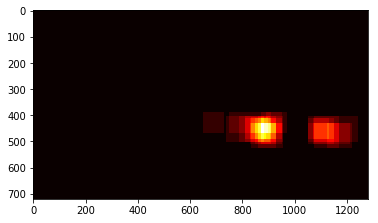

In [602]:
# Test heat map
img_heatmap = np.zeros_like(img[:,:,0])
img_heatmap = add_heat(img_heatmap,rectangles)
plt.imshow(img_heatmap, cmap='hot')

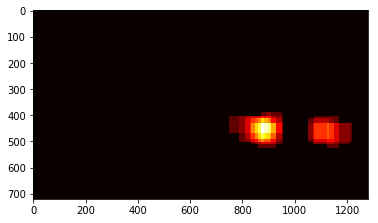

In [603]:
#Thresholding test
img_heatmap=apply_threshold(img_heatmap, 1)
plt.imshow(img_heatmap, cmap='hot')

Number of cars 2


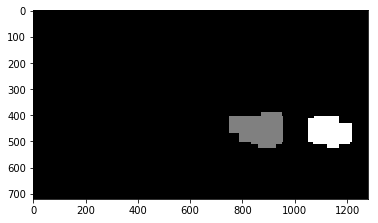

In [604]:
#Labelling and naming test
labels=label(img_heatmap)
#https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html
print('Number of cars', labels[1])
# Draw labels 
plt.imshow(labels[0],cmap='gray')

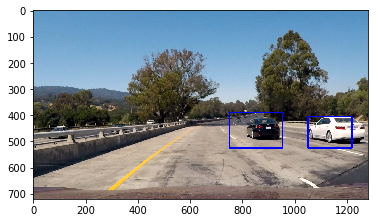

In [605]:
# Finally draw the final image
img_final = draw_labeled_bboxes(np.copy(img), labels)
plt.imshow(img_final)

#Rather efficient, even detects car in the other lane :)

In [620]:
class bounds():
    def __init__(self):
        self.rects_list=[]

    def addrects_list(self,new_rects):
        self.rects_list.append(new_rects)
        #Keep only last 10 rectangles
        if( len(self.rects_list) >10):
            self.rects_list = self.rects_list[len(self.rects_list)-10:]

In [621]:
def imagePipeline(image_stream):
    
    #Re-init rectangles in each frame
    bounding_rectangles=[]
    
    #Scale 1.0
    y_start=390
    y_end=500
    scale=1.0 
    bounding_rectangles += find_cars(image_stream, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = False)
  
    y_start=390
    y_end=540
    scale=1.25
    bounding_rectangles += find_cars(image_stream, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = False)
    
    #Scale 1.5
    y_start=405
    y_end=570
    scale=1.5
    bounding_rectangles += find_cars(image_stream, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = False)

    #Scale 1.75
    y_start=460
    y_end=610
    scale=1.5
    bounding_rectangles += find_cars(image_stream, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = False)
    #Scale 2.0
    y_start=470
    y_end=690
    scale=2.0
    bounding_rectangles += find_cars(image_stream, y_start, y_end, color_space, scale, classifier, 
                  scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw_all_rects = False)
 
    #Scale 3.0
    #y_start=480
    #y_end=690
    #scale=3.0
    #bounding_rectangles += find_cars(image_stream, y_start, y_end, color_space, scale, classifier, 
    #              scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    img_heatmap = np.zeros_like(image_stream[:,:,0])
    #Add rectangles to pipeline
    boxes.addrects_list(bounding_rectangles)
    
    # Add a heat image for upto 10 rectangles
    for each_rect in boxes.rects_list:
        img_heatmap = add_heat(img_heatmap, each_rect)
    img_heatmap = apply_threshold(img_heatmap,1+(len(boxes.rects_list)/2))
    
    car_labels = label(img_heatmap)
    img_final = draw_labeled_bboxes(image_stream, car_labels)
    return img_final

In [622]:
##Test all sample images

#1.
boxes = bounds()
image = mpimg.imread('test_images/test1.jpg') #image - Original image read
img_transformed = imagePipeline(image)
mpimg.imsave('test_images_output/test1_output.jpg', img_transformed)

#2.
boxes = bounds()
image = mpimg.imread('test_images/test2.jpg') #image - Original image read
img_transformed = imagePipeline(image)
mpimg.imsave('test_images_output/test2_output.jpg', img_transformed)

#3.
boxes = bounds()
image = mpimg.imread('test_images/test3.jpg') #image - Original image read
img_transformed = imagePipeline(image)
mpimg.imsave('test_images_output/test3_output.jpg', img_transformed)

#4.
boxes = bounds()
image = mpimg.imread('test_images/test4.jpg') #image - Original image read
img_transformed = imagePipeline(image)
mpimg.imsave('test_images_output/test4_output.jpg', img_transformed)

#5.
boxes = bounds()
image = mpimg.imread('test_images/test5.jpg') #image - Original image read
img_transformed = imagePipeline(image)
mpimg.imsave('test_images_output/test5_output.jpg', img_transformed)

#6.
boxes = bounds()
image = mpimg.imread('test_images/test6.jpg') #image - Original image read
img_transformed = imagePipeline(image)
mpimg.imsave('test_images_output/test6_output.jpg', img_transformed)

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [623]:
boxes = bounds()
yellow_output = 'test_videos_output/test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(10,17)
clip2 = VideoFileClip('./test_video.mp4')
yellow_clip = clip2.fl_image(imagePipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)
clip2.reader.close()
clip2.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/test_video_output.mp4
[MoviePy] Writing video test_videos_output/test_video_output.mp4


 97%|██████████████████████████████████████████████████████████████████████████  | 38/39 [00:28<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video_output.mp4 

Wall time: 30.2 s


In [624]:
boxes = bounds()
yellow_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('./project_video.mp4').subclip(20,34)
##clip3 = VideoFileClip('./project_video.mp4')
yellow_clip = clip3.fl_image(imagePipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)
clip3.reader.close()
clip3.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████▊| 350/351 [04:43<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 4min 45s
